### **Dataset: GoEmotions**

*GoEmotions* is a corpus of 58k carefully curated comments extracted from Reddit, with human annotations to 27 emotion categories or Neutral.

Number of examples: 58,009.
Number of labels: 27 + Neutral.

The data has already been separated in train, test and validation sets

Size of training dataset: 43,410.

Size of test dataset: 5,427.

Size of validation dataset: 5,426.

The emotion categories are: admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing libraries and importing data

In [ ]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.11.0


In [ ]:
# Importing raw comments and labels
df_train = pd.read_csv('/content/drive/MyDrive/GoEmotions_Git/data/train.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)
df_val = pd.read_csv('/content/drive/MyDrive/GoEmotions_Git/data/dev.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)
df_test = pd.read_csv('/content/drive/MyDrive/GoEmotions_Git/data/test.tsv', sep='\t', header=None, names=['Text', 'GE_indices', 'Id']).drop('Id', axis=1)

In [ ]:
# Preview of what data has been saved in the above variables
df_train[:10]

,Text,GE_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26
6,Yes I heard abt the f bombs! That has to be wh...,15
7,We need more boards and to create a bit more s...,"8,20"
8,Damn youtube and outrage drama is super lucrat...,0
9,It might be linked to the trust factor of your...,27


In [ ]:

df_test

,Text,GE_indices
0,I’m really sorry about your situation :( Altho...,25
1,It's wonderful because it's awful. At not with.,0
2,"Kings fan here, good luck to you guys! Will be...",13
3,"I didn't know that, thank you for teaching me ...",15
4,They got bored from haunting earth for thousan...,27
...,...,...
5422,Thanks. I was diagnosed with BP 1 after the ho...,15
5423,Well that makes sense.,4
5424,Daddy issues [NAME],27
5425,So glad I discovered that subreddit a couple m...,0


In [ ]:
df_val

,Text,GE_indices
0,Is this in New Orleans?? I really feel like th...,27
1,"You know the answer man, you are programmed to...","4,27"
2,I've never been this sad in my life!,25
3,The economy is heavily controlled and subsidiz...,"4,27"
4,He could have easily taken a real camera from ...,20
...,...,...
5421,It's pretty dangerous when the state decides w...,14
5422,I filed for divorce this morning. Hoping he mo...,20
5423,"The last time it happened I just said, ""No"" an...",10
5424,I can’t stand this arrogant prick he’s no bett...,3


Finding out how much percentage of data is represented by each

In [ ]:
# Defining the number of samples in train, validation and test dataset
size_train = df_train.shape[0]
size_val = df_val.shape[0]
size_test = df_test.shape[0]

# Defining the total number of samples
size_all = size_train + size_val + size_test

In [ ]:
# Shape of train, validation and test datasets
print("Train dataset has {} samples and represents {:.2f}% of overall data".format(size_train, size_train/size_all*100))
print("Validation dataset has {} samples and represents {:.2f}% of overall data".format(size_val, size_val/size_all*100))
print("Test dataset has {} samples and represents {:.2f}% of overall data".format(size_test, size_test/size_all*100))
print()
print("The total number of samples is : {}".format(size_all))

Train dataset has 43410 samples and represents 80.00% of overall data
Validation dataset has 5426 samples and represents 10.00% of overall data
Test dataset has 5427 samples and represents 10.00% of overall data

The total number of samples is : 54263


Finding out number of emotions in the dataset

In [ ]:
#For datatype
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        43410 non-null  object
 1   GE_indices  43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


Now, emotions.txt has all the set of emotions that this dataset contains.

Each emotion is mapped to a number as well, according to the sequence it is in, in the emotions.txt text file

In [ ]:
# Loading emotion labels for classification of emotions in GoEmotions dataset
with open("/content/drive/MyDrive/GoEmotions_Git/data/emotions.txt", "r") as file:
    GE_class = file.read().split("\n")

print(GE_class)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [ ]:
GE_class[25]

'sadness'

In [ ]:
print(len(GE_class))

28


Hence, there are 28 emotions, including 'neutral'

In [ ]:
#Counting the number of values under each emotion category
df_train.GE_indices.value_counts()

27           12823
0             2710
4             1873
15            1857
1             1652
             ...  
6,15,22          1
9,10,19          1
7,10,25          1
7,9,24,25        1
0,1,18           1
Name: GE_indices, Length: 711, dtype: int64

###Lambda Functions

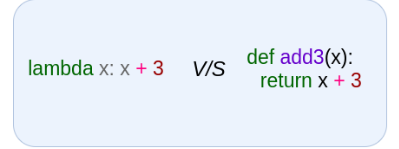

They can have any number of arguments but only one expression.

Before we start to further process the data, we will first have to combine all the three datasets into one and then proceed further

In [ ]:
# Combining all the 3 datasets into 1 dataset
df_all = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)

# Preview of data
display(df_all.head(3))

print(df_all.shape)

,Text,GE_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2


(54263, 2)


Next, we will have to map each GE_indices to it's corresponding emotion in the emotions.txt file

For that, let's first convert these GE_indices into a list of indices which we will then map to the emotions.txt file and extract the emotion labels from the file

In [ ]:
# We will use a lambda function here to make things easier
#df_all['GE_indices'] = df_all['GE_indices'].apply(lambda x: x.split(','))

In [ ]:
# Viewing the data for results
print(df_all.head)

<bound method NDFrame.head of                                                     Text GE_indices
0      My favourite food is anything I didn't have to...         27
1      Now if he does off himself, everyone will thin...         27
2                         WHY THE FUCK IS BAYLESS ISOING          2
3                            To make her feel threatened         14
4                                 Dirty Southern Wankers          3
...                                                  ...        ...
54258  Thanks. I was diagnosed with BP 1 after the ho...         15
54259                             Well that makes sense.          4
54260                                Daddy issues [NAME]         27
54261  So glad I discovered that subreddit a couple m...          0
54262  Had to watch "Elmo in Grouchland" one time too...         27

[54263 rows x 2 columns]>


Next steps:
1. Determine which emotions we want
2. Drop accordingly
3. Tokenization
4. Embedding
5. Vectorization
6. Models building

In [ ]:
df_all.isnull().sum()

Text          0
GE_indices    0
dtype: int64

In [ ]:
df_all

,Text,GE_indices
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
...,...,...
54258,Thanks. I was diagnosed with BP 1 after the ho...,15
54259,Well that makes sense.,4
54260,Daddy issues [NAME],27
54261,So glad I discovered that subreddit a couple m...,0


Dropping the un required emotions

In [ ]:
j=['0','1','3','4','5','6','7','8','9','10','11','12','13','15','16','18','19','20','21','22','23','24','26','27']

In [ ]:
df_final2 = pd.DataFrame()
emotions_selected=['2','14','17','25']#

for i in range(4):
   df_final2=df_final2.append(df_all.loc[df_all['GE_indices'] == emotions_selected[i]])
   print(emotions_selected[i])

print (df_final2)

2
14
17
25
                                                    Text GE_indices
2                         WHY THE FUCK IS BAYLESS ISOING          2
17                                       Fucking coward.          2
25                 Stupidly stubborn / stubbornly stupid          2
30     Troll, bro. They know they're saying stupid sh...          2
116                                  The fuck is “mog?!”          2
...                                                  ...        ...
54090                       I miss the confetti cakes :(         25
54137  I'm a little sad that there's not actually a v...         25
54172  Wife left me and I am just broken. relapsed to...         25
54175  I really pity those unfree Cuban babies. It’s ...         25
54178                                   Ik I’m crying rn         25

[3873 rows x 2 columns]


<ipython-input-102-a54a9a9f215c>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final2=df_final2.append(df_all.loc[df_all['GE_indices'] == emotions_selected[i]])
<ipython-input-102-a54a9a9f215c>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final2=df_final2.append(df_all.loc[df_all['GE_indices'] == emotions_selected[i]])
<ipython-input-102-a54a9a9f215c>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final2=df_final2.append(df_all.loc[df_all['GE_indices'] == emotions_selected[i]])
<ipython-input-102-a54a9a9f215c>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final2=df_final2.append(df_all.loc[df_all['GE_indices'] ==

In [ ]:
df_final2.head()

,Text,GE_indices
2,WHY THE FUCK IS BAYLESS ISOING,2
17,Fucking coward.,2
25,Stupidly stubborn / stubbornly stupid,2
30,"Troll, bro. They know they're saying stupid sh...",2
116,The fuck is “mog?!”,2


In [ ]:
one_hot_encoded_data = pd.get_dummies(df_final2, columns = ['GE_indices'])

In [ ]:
one_hot_encoded_data.head()

,Text,GE_indices_14,GE_indices_17,GE_indices_2,GE_indices_25
2,WHY THE FUCK IS BAYLESS ISOING,0,0,1,0
17,Fucking coward.,0,0,1,0
25,Stupidly stubborn / stubbornly stupid,0,0,1,0
30,"Troll, bro. They know they're saying stupid sh...",0,0,1,0
116,The fuck is “mog?!”,0,0,1,0


In [ ]:
df_final2.GE_indices.value_counts()

2     1265
17    1052
25    1003
14     553
Name: GE_indices, dtype: int64

In [ ]:
X = df_final2.iloc[:, 0].values
Y = one_hot_encoded_data.iloc[:, 1:5].values

In [ ]:
X

array(['WHY THE FUCK IS BAYLESS ISOING', 'Fucking coward.',
       'Stupidly stubborn / stubbornly stupid', ...,
       'Wife left me and I am just broken. relapsed tonight from 7 years clean and just not seeing a point anymore',
       'I really pity those unfree Cuban babies. It’s just sad.',
       'Ik I’m crying rn'], dtype=object)

In [ ]:
Y

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
print(X.shape)
print(Y.shape)

(3873,)
(3873, 4)


###Split data  into training and validation sets


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_sentences, val_sentences, train_labels, val_labels= train_test_split(X,
                                                                           Y,
                                                                           test_size=0.1,#use 20%of training data for validation
                                                                           random_state=42)

In [ ]:
len(train_sentences),len(train_labels),len(val_sentences), len(val_labels)

(3485, 3485, 388, 388)

In [ ]:
#checking the samples
train_sentences[:10], train_labels[:10]

(array(['You realize everyone sees you REEEEEEing all over the place right? You can act nonchalant all you want but obviously youre one salty sea dog',
        "Seems like you're another guy who hates legion ;D", 'Just stop.',
        'i think its cool because its a hybrid that comes in stickshift',
        'Just for recreational use? Glad you are having a change of mind though',
        "That's why I'm glad they got [NAME].",
        '... and no one seemed to care Except that lonely woman with white hair',
        "I might be alone here, but it was probably Blame Game. I don't think I heard a rap song with that much emotional intensity before.",
        'it made me cry too when [NAME] return to her older self😢',
        'I’m sorry friend. I actually used to be pretty good with this but I’m constantly getting worse.'],
       dtype=object), array([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0

##converting text to numbers
When dealing with text we needd to convert it into numbers

there are a few ways to do this
* Tokenisation- direct mapping of token(a token could be word or a character) to number
* Embedding - create a matrix of feature vector for each token (size of the feature vector can be defined and this embedding can be learned)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
!pipinstall tensorflow===2.10.0

/bin/bash: pipinstall: command not found


In [ ]:
#using default textvectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True)9

In [ ]:
#find the average num of tokens in the training tweets
round(sum([len(i.split())for i in train_sentences ])/len(train_sentences))

12

In [ ]:
#setup text vectorization variables
max_vocab_length=10000 # max num of words to have in our vocabulary
max_length= 15 #max length our sequences will be (eg how many words from a tweet does a model need to see)\

text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode="int",
                                  output_sequence_length=max_length)

In [ ]:
#fit the text vecctorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence="Wow we are finally implenting! aren't we great"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[236,  59,  22, 549,   1, 795,  59, 293,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
import random
random_sentence=random.choice(train_sentences)
print(f"Original text; \n {random_sentence}\
        \n\n Vectorized version:")
text_vectorizer([random_sentence])

Original text; 
 Pointless but fun        

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1888,   23,  104,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
# Get the unique words in vocabulary
words_in_vocab= text_vectorizer.get_vocabulary()
top_5_words= words_in_vocab[:5]#get 5 most common
bottom_5_words= words_in_vocab[-5:]#get 5 least common
print(f"Number of words in vocab:{len(words_in_vocab)}")
print(f"5 most common words in vocab:{top_5_words}")
print(f"5 most least words in vocab:{bottom_5_words}")

Number of words in vocab:6301
5 most common words in vocab:['', '[UNK]', 'the', 'i', 'to']
5 most least words in vocab:['110', '1000', '1', '018', '000001']


##Creating embedding layer
using tensors flows embeding layer

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Those things still haunt my dreams to this day.      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04809324, -0.04553536, -0.01337464, ...,  0.04469284,
         -0.04051531, -0.01093571],
        [-0.02202821,  0.04237569, -0.03835442, ..., -0.00149481,
         -0.01199568, -0.03506467],
        [-0.02950199, -0.0130878 ,  0.0331757 , ..., -0.04696765,
          0.01309757, -0.04758787],
        ...,
        [-0.00639687,  0.02625461,  0.04189365, ...,  0.03356859,
          0.02596034,  0.03694897],
        [-0.00639687,  0.02625461,  0.04189365, ...,  0.03356859,
          0.02596034,  0.03694897],
        [-0.00639687,  0.02625461,  0.04189365, ...,  0.03356859,
          0.02596034,  0.03694897]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04809324, -0.04553536, -0.01337464, -0.04982675, -0.02996667,
         0.00490301,  0.04928522,  0.03284952, -0.00634767,  0.00384798,
        -0.00698926,  0.04331188,  0.03644678,  0.01062191, -0.00035523,
        -0.01239668,  0.01759023,  0.04538887, -0.02180792, -0.04814089,
         0.04415262, -0.02257508,  0.01851794,  0.02251064,  0.00364287,
        -0.00210297, -0.04168922,  0.03263335,  0.04476038, -0.04346833,
        -0.03293742, -0.03133928,  0.04175169,  0.00194619,  0.03302698,
         0.03479362,  0.04870054, -0.03366702, -0.03620879, -0.04755279,
         0.04922893,  0.0358541 , -0.02480274,  0.03870853, -0.00683283,
        -0.03538359,  0.04499033,  0.01190837,  0.00251961,  0.04978443,
        -0.03558023,  0.02659339, -0.02198697, -0.04866848, -0.02351612,
         0.02535443, -0.00214473,  0.04143134, -0.04808425, -0.04686215,
         0.04246132,  0.02484686, -0.00433489,  0.00362501,  0.04864501,
  

###Modelling a text dataset (running a series of experiements )

### Creating an evaluation function for our model experiments

We can evaluate all of our model's predictions with different metrics every single time, but that will become very cumbersome.

For this, we will create a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics: accuracy, precision, recall, f1 score

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
#import series of helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-03-28 15:57:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-28 15:57:44 (94.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Function to evaluate: accuracy, precision, recall, f1 score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Parameters:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results
  # _ is used as an blank variable because we dont want 'support' which is a type of return in the function

##Model 1: A simple dense model
The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer.

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our create_tensorboard_callback() function from helper_functions.py to keep track of the results of each.


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(4, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
# Compile model
model_1.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,280,516
Trainable params: 1,280,516
N

In [ ]:
 train_sentences_list = train_sentences.tolist()

In [ ]:
val_sentences_list = val_sentences.tolist()

In [ ]:
print(train_sentences.shape)

(3485,)


In [ ]:
type(train_labels)

numpy.ndarray

In [ ]:
print(train_labels.shape)

(3485, 4)


In [ ]:
i=0

In [ ]:
len(train_labels)

3485

In [ ]:
train_labels[0]='1'

In [ ]:
train_labels1

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
train_labels

array([[1, 1, 1, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [ ]:
train_labels2

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
val_labels2

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, #input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels2,
                              epochs=5,
                              validation_data=(val_sentences, val_labels2),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230328-155744
Epoch 1/5
109/109 [==============================] - 7s 60ms/step - loss: 1.3312 - accuracy: 0.4227 - val_loss: 1.2767 - val_accuracy: 0.4845
Epoch 2/5
109/109 [==============================] - 2s 22ms/step - loss: 1.1868 - accuracy: 0.5920 - val_loss: 1.1302 - val_accuracy: 0.6082
Epoch 3/5
109/109 [==============================] - 1s 14ms/step - loss: 0.9542 - accuracy: 0.7231 - val_loss: 0.9467 - val_accuracy: 0.6881
Epoch 4/5
109/109 [==============================] - 1s 6ms/step - loss: 0.7098 - accuracy: 0.8402 - val_loss: 0.7941 - val_accuracy: 0.7423
Epoch 5/5
109/109 [==============================] - 1s 7ms/step - loss: 0.5170 - accuracy: 0.8999 - val_loss: 0.6984 - val_accuracy: 0.7990


In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, #input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels2,
                              epochs=10,
                              validation_data=(val_sentences, val_labels2),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230328-155757
Epoch 1/10
109/109 [==============================] - 1s 5ms/step - loss: 0.3839 - accuracy: 0.9360 - val_loss: 0.6376 - val_accuracy: 0.7990
Epoch 2/10
109/109 [==============================] - 0s 5ms/step - loss: 0.2938 - accuracy: 0.9584 - val_loss: 0.6043 - val_accuracy: 0.8093
Epoch 3/10
109/109 [==============================] - 0s 5ms/step - loss: 0.2298 - accuracy: 0.9696 - val_loss: 0.5866 - val_accuracy: 0.8196
Epoch 4/10
109/109 [==============================] - 0s 4ms/step - loss: 0.1837 - accuracy: 0.9773 - val_loss: 0.5739 - val_accuracy: 0.8119
Epoch 5/10
109/109 [==============================] - 0s 4ms/step - loss: 0.1497 - accuracy: 0.9822 - val_loss: 0.5712 - val_accuracy: 0.8067
Epoch 6/10
109/109 [==============================] - 0s 4ms/step - loss: 0.1241 - accuracy: 0.9865 - val_loss: 0.5703 - val_accuracy: 0.8144
Epoch 7/10
109/109 [==============================] - 1s 6ms/step - l

In [ ]:
# Check the results on the validation set
model_1.evaluate(val_sentences, val_labels2)

13/13 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.8067


[0.596808910369873, 0.8067010045051575]

In [ ]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.01959939,  0.02457518,  0.03105819, ...,  0.03390099,
          0.03456484,  0.03689034],
        [ 0.00816988,  0.03585285, -0.01391339, ..., -0.03787583,
         -0.01198913,  0.01403182],
        [-0.05233935,  0.04211326, -0.00253452, ...,  0.02746399,
         -0.03935302,  0.00246225],
        ...,
        [ 0.00078622, -0.01020336, -0.00559466, ..., -0.043355  ,
         -0.03880214,  0.0434222 ],
        [-0.04747633,  0.02222211, -0.02189552, ..., -0.04778212,
          0.02577616,  0.01931937],
        [ 0.04681138, -0.04062483, -0.01621222, ...,  0.02371501,
         -0.04587724,  0.04653705]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:20] # only print out the first 10 prediction probabilities

13/13 [==============================] - 0s 2ms/step


array([[1.06942341e-01, 1.67571625e-03, 1.24641648e-03, 8.90135527e-01],
       [1.27938315e-02, 1.04891352e-01, 3.01603600e-03, 8.79298806e-01],
       [5.28415199e-03, 6.74764335e-01, 6.78102076e-02, 2.52141356e-01],
       [3.15179825e-01, 2.69606560e-01, 1.07035786e-01, 3.08177799e-01],
       [2.29042858e-01, 2.37364933e-01, 6.25635535e-02, 4.71028656e-01],
       [7.72426575e-02, 8.05525720e-01, 6.25016261e-03, 1.10981464e-01],
       [2.85206293e-03, 9.83264744e-01, 7.64321908e-03, 6.24000188e-03],
       [5.01342220e-05, 4.47838247e-05, 9.99763191e-01, 1.41979574e-04],
       [2.66566640e-03, 8.99672806e-01, 9.31252390e-02, 4.53624642e-03],
       [1.09210042e-02, 5.40114334e-03, 8.29351321e-03, 9.75384235e-01],
       [4.14560316e-03, 2.41791154e-03, 4.62389056e-04, 9.92974162e-01],
       [4.77261633e-01, 6.51891083e-02, 1.70143425e-01, 2.87405789e-01],
       [1.88367630e-04, 2.12333980e-03, 9.93094563e-01, 4.59368015e-03],
       [2.86922418e-03, 9.53598440e-01, 4.13505584e

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

In [ ]:
val_labels2[:20]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [ ]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels2,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 77.0618556701031,
 'precision': 0.8408962579825913,
 'recall': 0.770618556701031,
 'f1': 0.803728806842776}

###Model 2: LSTM

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(4, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
# Compile model
model_2.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,329,668
Trainable params: 1,329,668
Non-trainable params: 0
____________________________________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels2,
                              epochs=5,
                              validation_data=(val_sentences, val_labels2),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230328-155808
Epoch 1/5
109/109 [==============================] - 12s 90ms/step - loss: 1.2430 - accuracy: 0.4098 - val_loss: 0.9855 - val_accuracy: 0.5206
Epoch 2/5
109/109 [==============================] - 2s 17ms/step - loss: 0.5349 - accuracy: 0.8095 - val_loss: 0.6358 - val_accuracy: 0.7603
Epoch 3/5
109/109 [==============================] - 2s 16ms/step - loss: 0.1929 - accuracy: 0.9486 - val_loss: 0.7158 - val_accuracy: 0.7423
Epoch 4/5
109/109 [==============================] - 1s 8ms/step - loss: 0.0885 - accuracy: 0.9773 - val_loss: 0.8617 - val_accuracy: 0.7655
Epoch 5/5
109/109 [==============================] - 1s 9ms/step - loss: 0.0621 - accuracy: 0.9865 - val_loss: 0.8504 - val_accuracy: 0.7629


In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

13/13 [==============================] - 1s 4ms/step


((388, 4),
 array([[6.44355834e-01, 2.08092555e-02, 2.47482304e-02, 3.10086668e-01],
        [5.35864430e-03, 1.61324569e-04, 1.11115724e-03, 9.93368924e-01],
        [2.74582114e-03, 9.47812106e-04, 2.17523915e-03, 9.94131148e-01],
        [1.01608984e-01, 2.31256709e-01, 4.16503578e-01, 2.50630707e-01],
        [1.98746115e-01, 1.44152537e-01, 2.75349170e-01, 3.81752163e-01],
        [2.32900865e-02, 8.48152459e-01, 1.06494268e-02, 1.17908016e-01],
        [3.07253096e-04, 9.99153852e-01, 5.50305267e-05, 4.83810931e-04],
        [3.62257299e-04, 7.02332531e-04, 9.96989965e-01, 1.94543716e-03],
        [2.12455261e-03, 9.92841601e-01, 1.81384990e-03, 3.21992463e-03],
        [2.17274964e-01, 2.35004234e-03, 4.58906032e-03, 7.75785923e-01]],
       dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels2,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 74.48453608247422,
 'precision': 0.7988221081871079,
 'recall': 0.7448453608247423,
 'f1': 0.7703479626126419}

###Model 3: GRU

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(4, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Compile GRU model
model_3.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,317,508
Trainable params: 1,317,508
Non-trainable params: 0
_____________________________________________

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels2,
                              epochs=4,
                              validation_data=(val_sentences, val_labels2),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230328-155831
Epoch 1/4
109/109 [==============================] - 9s 60ms/step - loss: 1.3446 - accuracy: 0.3311 - val_loss: 1.3132 - val_accuracy: 0.3814
Epoch 2/4
109/109 [==============================] - 2s 17ms/step - loss: 0.8644 - accuracy: 0.6585 - val_loss: 0.6290 - val_accuracy: 0.7500
Epoch 3/4
109/109 [==============================] - 3s 26ms/step - loss: 0.2640 - accuracy: 0.9159 - val_loss: 0.6097 - val_accuracy: 0.7990
Epoch 4/4
109/109 [==============================] - 1s 10ms/step - loss: 0.0997 - accuracy: 0.9730 - val_loss: 0.8165 - val_accuracy: 0.7758


In [ ]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

13/13 [==============================] - 0s 3ms/step


((388, 4), array([[9.7835334e-03, 1.1084091e-03, 6.8201200e-04, 9.8842609e-01],
        [2.9443434e-04, 1.2399708e-03, 2.0301667e-04, 9.9826258e-01],
        [1.5067183e-03, 7.7589887e-01, 1.0443609e-02, 2.1215078e-01],
        [2.3165146e-02, 6.5738153e-01, 1.4830865e-01, 1.7114469e-01],
        [1.0338399e-01, 1.4511338e-01, 3.8168553e-02, 7.1333396e-01],
        [1.7732250e-02, 5.8896410e-01, 8.9209368e-03, 3.8438272e-01],
        [1.7151440e-04, 9.9803239e-01, 7.3197414e-05, 1.7228810e-03],
        [1.2944812e-04, 2.9959384e-04, 9.9925262e-01, 3.1834320e-04],
        [2.6580475e-03, 9.5765984e-01, 2.5441987e-02, 1.4240079e-02],
        [6.8737078e-03, 1.1762158e-03, 1.0758857e-03, 9.9087417e-01]],
       dtype=float32))

In [ ]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels2,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.03092783505154,
 'precision': 0.8138561934875315,
 'recall': 0.7603092783505154,
 'f1': 0.7819210195566584}

###Model 4: Bidirectonal RNN model

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(4, activation="softmax")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
# Compile
model_4.compile(loss="CategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,379,332
Trainable params: 1,3

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels2,
                              epochs=10,
                              validation_data=(val_sentences, val_labels2),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230328-155848
Epoch 1/10
109/109 [==============================] - 12s 76ms/step - loss: 1.1721 - accuracy: 0.4809 - val_loss: 0.7646 - val_accuracy: 0.6856
Epoch 2/10
109/109 [==============================] - 2s 18ms/step - loss: 0.4581 - accuracy: 0.8373 - val_loss: 0.6781 - val_accuracy: 0.7552
Epoch 3/10
109/109 [==============================] - 2s 17ms/step - loss: 0.1474 - accuracy: 0.9549 - val_loss: 0.7284 - val_accuracy: 0.7912
Epoch 4/10
109/109 [==============================] - 1s 9ms/step - loss: 0.0695 - accuracy: 0.9802 - val_loss: 0.8911 - val_accuracy: 0.7835
Epoch 5/10
109/109 [==============================] - 1s 11ms/step - loss: 0.0308 - accuracy: 0.9934 - val_loss: 1.0209 - val_accuracy: 0.7809
Epoch 6/10
109/109 [==============================] - 1s 7ms/step - loss: 0.0199 - accuracy: 0.9945 - val_loss: 1.0829 - val_accuracy: 0.7784
Epoch 7/10
109/109 [==============================] - 1s 8ms/step

In [ ]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

13/13 [==============================] - 1s 5ms/step


array([[2.0295593e-04, 6.5997301e-07, 2.6131454e-06, 9.9979383e-01],
       [9.0733066e-04, 7.6990336e-06, 5.5345226e-06, 9.9907947e-01],
       [2.0894468e-06, 9.9100000e-01, 2.9191453e-04, 8.7059252e-03],
       [7.4948365e-04, 2.6181301e-01, 5.8211023e-01, 1.5532720e-01],
       [4.2595371e-04, 4.4637006e-02, 8.3098337e-02, 8.7183869e-01],
       [3.5037632e-05, 9.9983561e-01, 1.8569883e-06, 1.2749393e-04],
       [2.1501050e-05, 9.9855250e-01, 4.1507526e-05, 1.3844264e-03],
       [8.3825728e-07, 4.4668101e-07, 9.9998260e-01, 1.6038721e-05],
       [3.0008382e-06, 9.9998629e-01, 2.3587838e-06, 8.3820814e-06],
       [3.5979923e-05, 1.4630388e-05, 8.9285453e-04, 9.9905652e-01]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels2, model_4_preds)
model_4_results

{'accuracy': 74.74226804123711,
 'precision': 0.7619469990527493,
 'recall': 0.7474226804123711,
 'f1': 0.7498446643277848}

In [ ]:
model_1_results

{'accuracy': 77.0618556701031,
 'precision': 0.8408962579825913,
 'recall': 0.770618556701031,
 'f1': 0.803728806842776}

In [ ]:
model_2_results

{'accuracy': 74.48453608247422,
 'precision': 0.7988221081871079,
 'recall': 0.7448453608247423,
 'f1': 0.7703479626126419}

In [ ]:
model_3_results

{'accuracy': 76.03092783505154,
 'precision': 0.8138561934875315,
 'recall': 0.7603092783505154,
 'f1': 0.7819210195566584}

In [ ]:
model_4_results

{'accuracy': 74.74226804123711,
 'precision': 0.7619469990527493,
 'recall': 0.7474226804123711,
 'f1': 0.7498446643277848}

In [ ]:
sen=['what the hell is this','wow amazing this good','pls dont hurt me i dont like it']
guess=model_4.predict(sen)
guess

1/1 [==============================] - 0s 117ms/step


array([[3.1264162e-06, 4.0584524e-05, 9.9891698e-01, 1.0393563e-03],
       [6.2552631e-06, 9.9965560e-01, 1.3494769e-05, 3.2469307e-04],
       [1.8486533e-04, 4.3497480e-06, 9.2829549e-04, 9.9888247e-01]],
      dtype=float32)

In [ ]:
tf.squeeze(tf.round(guess))


<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [ ]:
#14-fear, 17-joy, 2-angry, 25- sadnessS